In [1]:
%matplotlib inline

In [2]:
import astra
import numpy as np
import pylab as plt
import os
import glob

import matplotlib
font = {'size'   : 18}
matplotlib.rc('font', **font)

In [3]:
from scipy.signal import medfilt

In [4]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = unicode(index or '?')

In [5]:
def images_diff(im1, im2):
    assert(im1.shape==im2.shape)
    rec_diff = np.zeros(shape=(im1.shape[0],im1.shape[1],3), dtype='float32')
    im1_t = im1.copy()
    im1_t = (im1_t-im1_t.min())/(im1_t.max()-im1_t.min())
    
    im2_t = im2.copy()
    im2_t = (im2_t-im2_t.min())/(im2_t.max()-im2_t.min())
    
    # nrecon_rec_t[nrecon_rec_t<0] = 0
    diff_rec = im1_t-im2_t
    rec_diff[...,0] = diff_rec*(diff_rec>0)
    rec_diff[...,1] = -diff_rec*(diff_rec<0)
    rec_diff[...,2] = rec_diff[...,1]
    return rec_diff

In [34]:
!ls /home/makov/diskmnt/big/yaivan/RC/MMC1_2.82um_/

bh_92_rc_0   bh_92_rc_14  bh_92_rc_2   bh_92_rc_25  bh_92_rc_30  bh_92_rc_9
bh_92_rc_1   bh_92_rc_15  bh_92_rc_20  bh_92_rc_26  bh_92_rc_4
bh_92_rc_10  bh_92_rc_16  bh_92_rc_21  bh_92_rc_27  bh_92_rc_5
bh_92_rc_11  bh_92_rc_17  bh_92_rc_22  bh_92_rc_28  bh_92_rc_6
bh_92_rc_12  bh_92_rc_18  bh_92_rc_23  bh_92_rc_29  bh_92_rc_7
bh_92_rc_13  bh_92_rc_19  bh_92_rc_24  bh_92_rc_3   bh_92_rc_8


In [7]:
!ls /home/makov/diskmnt/big/yaivan/MMC_1/_tmp/nrecon/bh_0_rc_0/

MMC1_2.82um__pp1.tif	  MMC1_2.82um__rec_spr.bmp
MMC1_2.82um__pp2.tif	  MMC1_2.82um__sino0960.tif
MMC1_2.82um__rec0960.png  MMC1_2.82um__sinoraw_0960.tif
MMC1_2.82um__rec.log	  tomo_config.log


In [27]:
!ls '/home/makov/diskmnt/big/yaivan/Sand/Reconstructed/

ls: cannot access /home/makov/diskmnt/big/yaivan/Sand/Reconstructed/*.log: No such file or directory


In [8]:
def get_bh_level(nf):
    return(int(os.path.split(nf)[-1].split('_')[1]))
def get_rc_level(nf):
    return(int(os.path.split(nf)[-1].split('_')[3]))

In [42]:
def get_data(folder):
    try:
        data_file = glob.glob(os.path.join(folder, '*_sino*.tif'))[0]
    #     print(data_file)
        sinogram = plt.imread(data_file).astype('float32')
        data_file = glob.glob(os.path.join(folder, '*_sinoraw_*.tif'))[0]
        sinraw = plt.imread(data_file).astype('float32')
        rec_file = glob.glob(os.path.join(folder, '*_rec*.png'))[0]
        rec = plt.imread(rec_file).astype('float32')
    except e:
        print 'folder'
        raise e
        
    return sinogram, sinraw, rec

In [55]:
objects = []
# objects.append({'name':'MMC_1',
#                 'data_root':'/home/makov/diskmnt/big/yaivan/RC/MMC1_2.82um_/',
#                 'rc_ref':16})
# objects.append({'name':'Sand',
#                 'data_root':'/home/makov/diskmnt/big/yaivan/RC/Chieftain_Unc_2.8_/',
#                 'rc_ref':20})
# objects.append({'name':'HP_Stage',
#                 'data_root':'/home/makov/diskmnt/big/yaivan/RC/S2-Barnett@HP_P1_2.99um_/',
#                 'rc_ref':20})
objects.append({'name':'Model object',
                'data_root':'/home/makov/diskmnt/big/yaivan/RC/cube_/',
                'rc_ref':0})

31
4 0 20 15 12 6 24 29 23 9 30 25 11 19 26 22 1 2 3 27 5 18 21 8 16 14 13 10 28 17 7


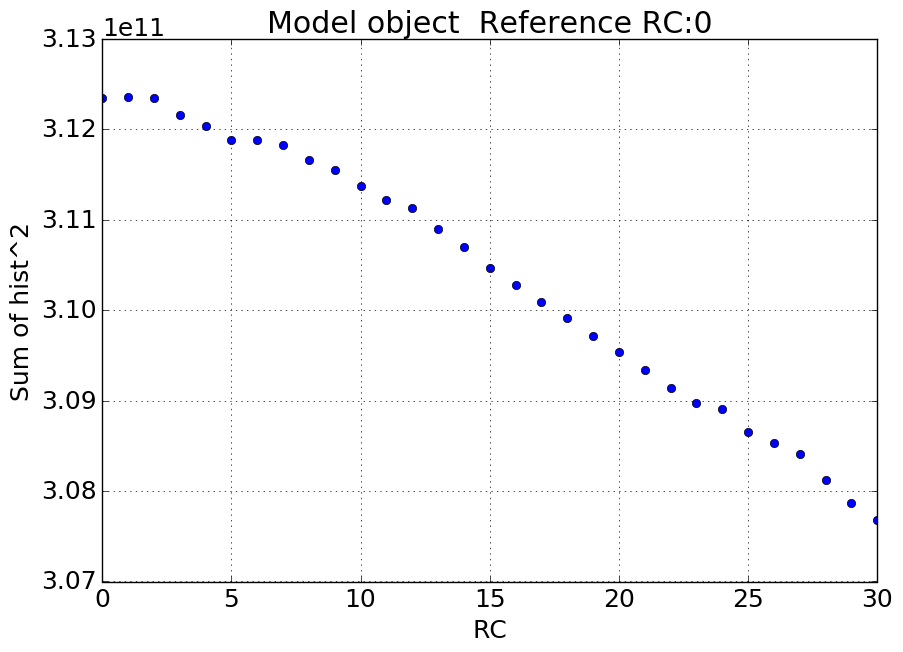

In [56]:
for rc_object in objects:# data_root = '/home/makov/diskmnt/big/yaivan/MMC_1/_tmp/nrecon/'
    data_root= rc_object['data_root']
    # nrecon_root_folder = os.path.join(data_root,'_tmp','nrecon')
    nrecon_folders = glob.glob(os.path.join(data_root, 'bh_*_rc_*'))
    nrecon_folders = [nf for nf in nrecon_folders if os.path.isdir(nf)]
    print len(nrecon_folders)
    for nf in nrecon_folders:
        print get_rc_level(nf),
    print
    
    sino = {}
    sinoraw = {}
    rec ={}
    for nf in log_progress(nrecon_folders):
        rc_level =  get_rc_level(nf)
        sino[rc_level], sinoraw[rc_level], rec[rc_level] = get_data(nf)
        
    h={}
    for k, v in log_progress(list(rec.iteritems())):
        r = rec[k]
        h[k], _ = np.histogram(r,bins=1000)
    
    x = []
    y = []
    for k,v in h.iteritems():
        x.append(k)
        y.append(np.sum(v**2))
                 
    plt.figure(figsize=(10,7))
    plt.title('{}  Reference RC:{}'.format(rc_object['name'],rc_object['rc_ref']))
    plt.plot(x,y,'o')
    plt.ylabel('Sum of hist^2')
    plt.xlabel('RC')
    plt.grid(True)
    plt.show()

In [57]:
sino = {}
sinoraw = {}
rec ={}
for nf in log_progress(nrecon_folders):
    rc_level =  get_rc_level(nf)
    sino[rc_level], sinoraw[rc_level], rec[rc_level] = get_data(nf)

In [44]:
h={}
for k, v in log_progress(list(rec.iteritems())):
    r = rec[k]
    h[k], _ = np.histogram(r,bins=1000)

In [45]:
x = []
y = []
for k,v in h.iteritems():
    x.append(k)
    y.append(np.sum(v**2))

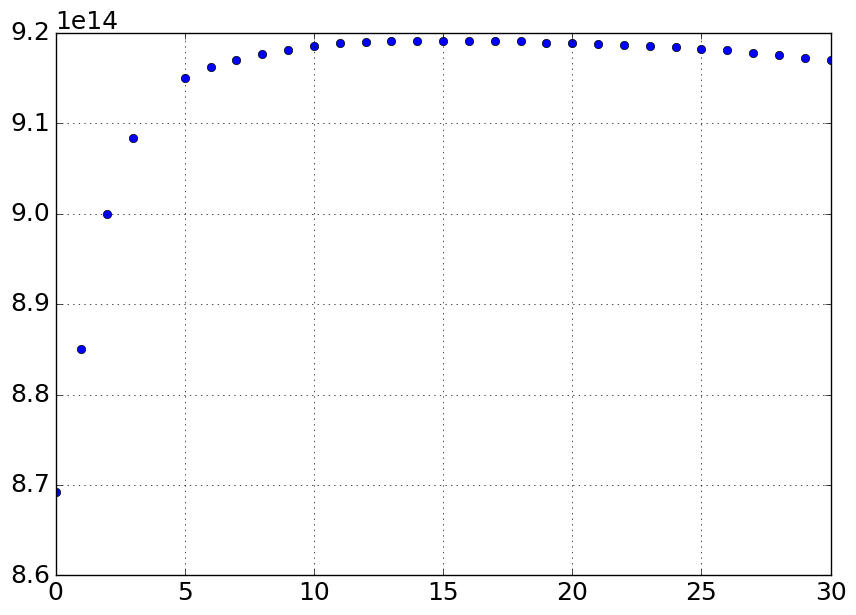

In [47]:
plt.figure(figsize=(10,7))
plt.plot(x,y,'o')
plt.grid(True)
plt.show()